# Import Module

In [1]:
!pip install wordcloud 

In [2]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
import nltk 
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords


#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikhael.bratanata\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data Preparation

In [33]:
#iport dataset 
dataset = pd.read_csv('D:/Data Science Bootcamp/Day 8/data/train.csv')
dataset.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
#get text and response 
df = dataset[['Description','Is_Response']]

## A. Preprocessing 

### A.1. Data Cleansing

In [5]:
#cleansing 
def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub('-\[[^]]*\]', '', text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)
    def remove_non_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

In [6]:
# #apply function 
df['Description'] = df['Description'].progress_apply(preprocessing)

100%|██████████| 38932/38932 [00:04<00:00, 7908.19it/s]
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
#stopwords.words('indonesian')

### A.2. Preprocessing

In [8]:
#stopword 
stop = stopwords.words('english')
df['Description'] = df['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#lematization 
df['Description']  = df['Description'] .apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### A.2. Data Exploration

In [10]:
#count sentiment 
sentiment = df.groupby(['Is_Response'])['Is_Response'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['Is_Response']
chart.drop(['Is_Response'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,Is_Response,tweet_count,percent
0,happy,26521,0.681213
1,not happy,12411,0.318787


#### 1. Barchart

Text(0.5, 1.0, 'Sentiment Class')

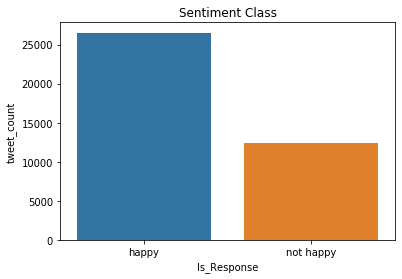

In [11]:
#visualization 
ax = sns.barplot(x= 'Is_Response', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

#### 2. Wordcloud

In [12]:
#define happy and not happy 
happy = df.loc[df['Is_Response'] == "happy"]
not_happy  = df.loc[df['Is_Response'] == "not happy"]

In [13]:
#merge all the happy comments into one paragraph
all_description_happy = "".join(happy.Description.values)
all_description_not_happy = "".join(not_happy.Description.values)

In [14]:
#text = happy.Description
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

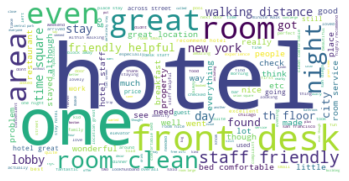

In [15]:
#happy 
create_word_cloud(all_description_happy)

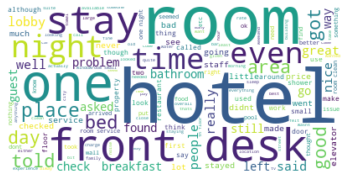

In [16]:
#nothappy
create_word_cloud(all_description_not_happy)

## B. Feature Extraction

### 1. Count Vectorizer 

In [17]:
count_vectorizer = CountVectorizer(stop_words='english')

### 1. TF-IDF vectorizer 

In [18]:
tfidf = TfidfVectorizer(stop_words='english')

## C. Modeling 

### 1. Train Test Split

In [19]:
X = df['Description']
y = df['Is_Response']

In [20]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

In [21]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

### 2. Model Machine Learning

In [22]:
# a. Logistic regression
# b. Naive Bayes

#### a. Logistic Regression

In [23]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

#### b. Naive Bayes

In [25]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [26]:
# TFIDFVectorizer
#from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

#### c. Another Algorithm

In [27]:
#

### 3. Model Evaluation

The following option are kind of model evaluation that used.  
- Precision = precision_score()
- Recall = recall_score() 
- F_measure = f1_score()

#### a. Logistic Regression

In [28]:
# using count vectorizer
print("______________ Countvectorizer ______________")

# Lr_clf_vec_report_train = classification_report(train_y, Lr_pred_vect_train)
# Lr_clf_vec_report_test = classification_report(test_y, Lr_pred_vect_test)

# Lr_confmatrix_vect_train = confusion_matrix(train_y, Lr_pred_vect_train) 
# Lr_confmatrix_vect_test = confusion_matrix(test_y, Lr_pred_vect_test)

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
# print('Confusion matrix for Train :')
# print(Lr_confmatrix_vect_train,'\n')
# print('Confusion matrix for Test :')
# print(Lr_confmatrix_vect_test,'\n')
# print('Classification Refort for Train :')
# print(Lr_clf_vec_report_train,'\n')
# print('Classification Refort for Test :')
# print(Lr_clf_vec_report_test,'\n')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 96.90% & 87.09%
Precision train & test  : 96.90% & 87.09%
F1 Score train & test   : 96.90% & 87.09%


In [29]:
# using count vectorizer
print("______________ TF-IDF ______________")


Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 91.04% & 88.31%
Precision train & test  : 91.04% & 88.31%
F1 Score train & test   : 91.04% & 87.09%


#### b. Naive Bayes

In [30]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")


NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 89.22% & 86.61%
Precision train & test  : 89.22% & 86.61%
F1 Score train & test   : 89.22% & 86.61%


In [31]:
# using count vectorizer
print("______________ TF-IDF ______________")


NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 80.80% & 79.03%
Precision train & test  : 80.80% & 79.03%
F1 Score train & test   : 80.80% & 86.61%


#### c. Another Alogirthm

In [32]:
#lets try by yourself 